<a href="https://colab.research.google.com/github/SSM11011/Predicting-User-Churn-for-an-E-commerce-Platform/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    return summary

In [ ]:
df = pd.read_csv("/content/events.csv")
resumetable(df)

Dataset Shape: (885129, 9)


,Name,dtypes,Missing,Uniques,First Value,Second Value
0,event_time,object,0,845041,2020-09-24 11:57:06 UTC,2020-09-24 11:57:26 UTC
1,event_type,object,0,3,view,view
2,product_id,int64,0,53453,1996170,139905
3,category_id,int64,0,718,2144415922528452715,2144415926932472027
4,category_code,object,236219,107,electronics.telephone,computers.components.cooler
5,brand,object,212364,999,NaN,zalman
6,price,float64,0,12422,31.9,17.16
7,user_id,int64,0,407283,1515915625519388267,1515915625519380411
8,user_session,object,165,490398,LJuJVLEjPT,tdicluNnRY


In [ ]:
df["event_time_col"] = pd.to_datetime(df["event_time"])

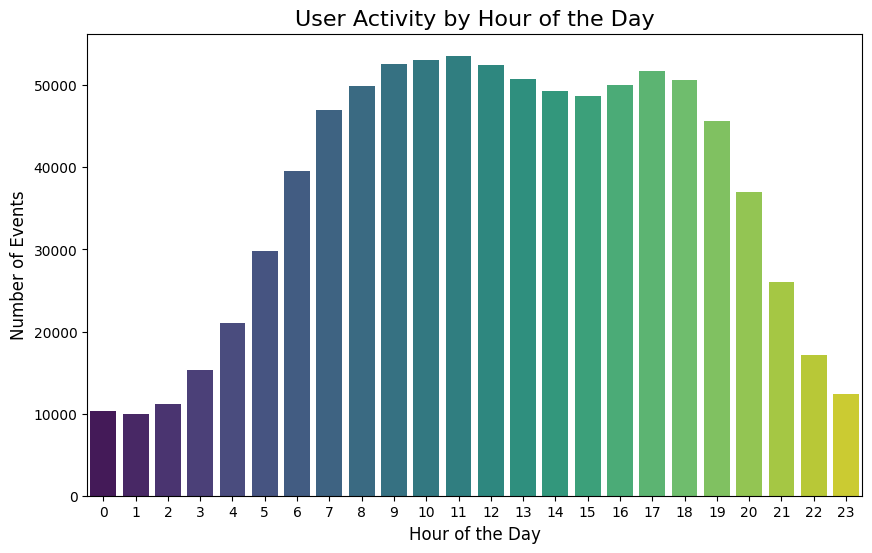

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=df['event_time_col'].dt.hour, palette='viridis')
plt.title('User Activity by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.show()

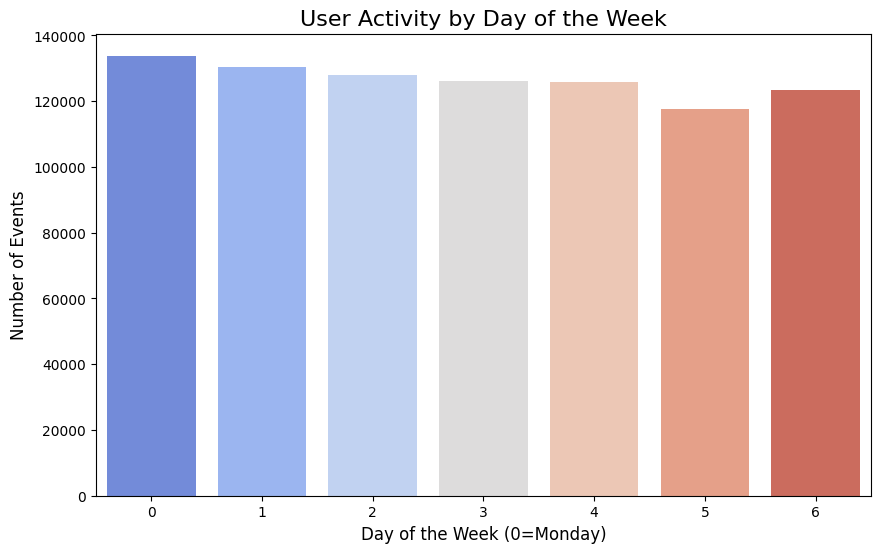

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=df['event_time_col'].dt.dayofweek, palette='coolwarm')
plt.title('User Activity by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week (0=Monday)', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.show()

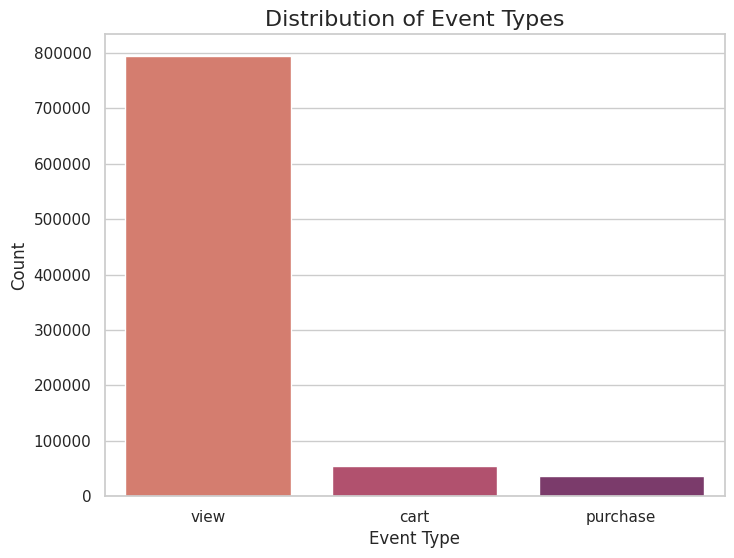

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.countplot(data=df, x='event_type', hue='event_type', palette='flare')
plt.title('Distribution of Event Types', fontsize=16)
plt.xlabel('Event Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

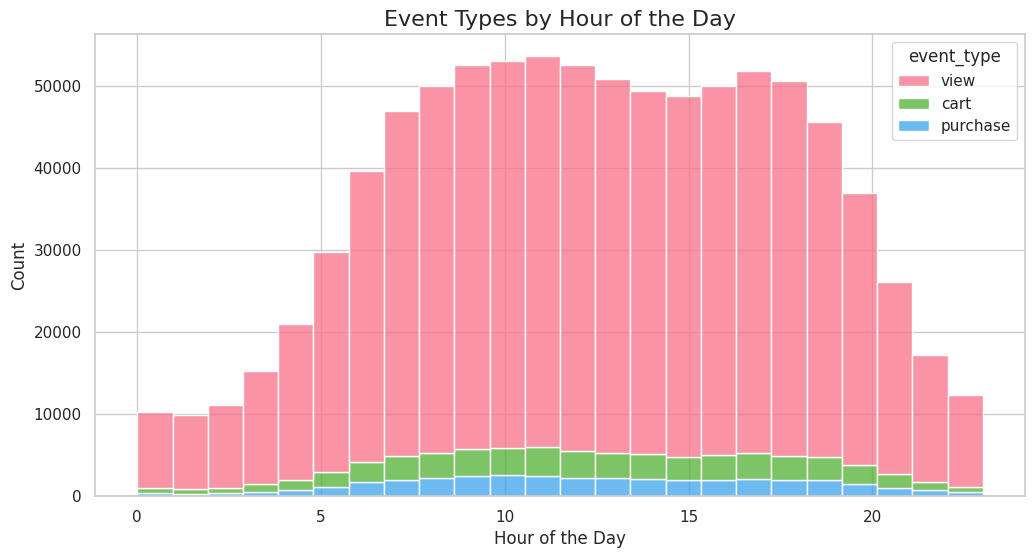

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x=df['event_time_col'].dt.hour, hue='event_type', multiple='stack', palette='husl', bins=24)
plt.title('Event Types by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

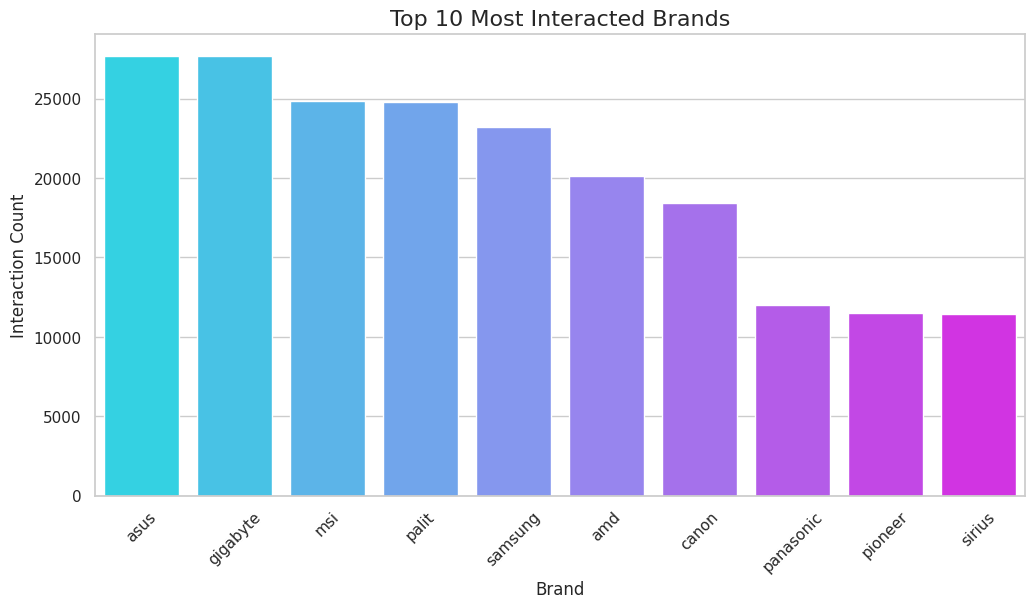

In [ ]:
top_brands = df['brand'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_brands.index, y=top_brands.values, palette='cool')
plt.title('Top 10 Most Interacted Brands', fontsize=16)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Interaction Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

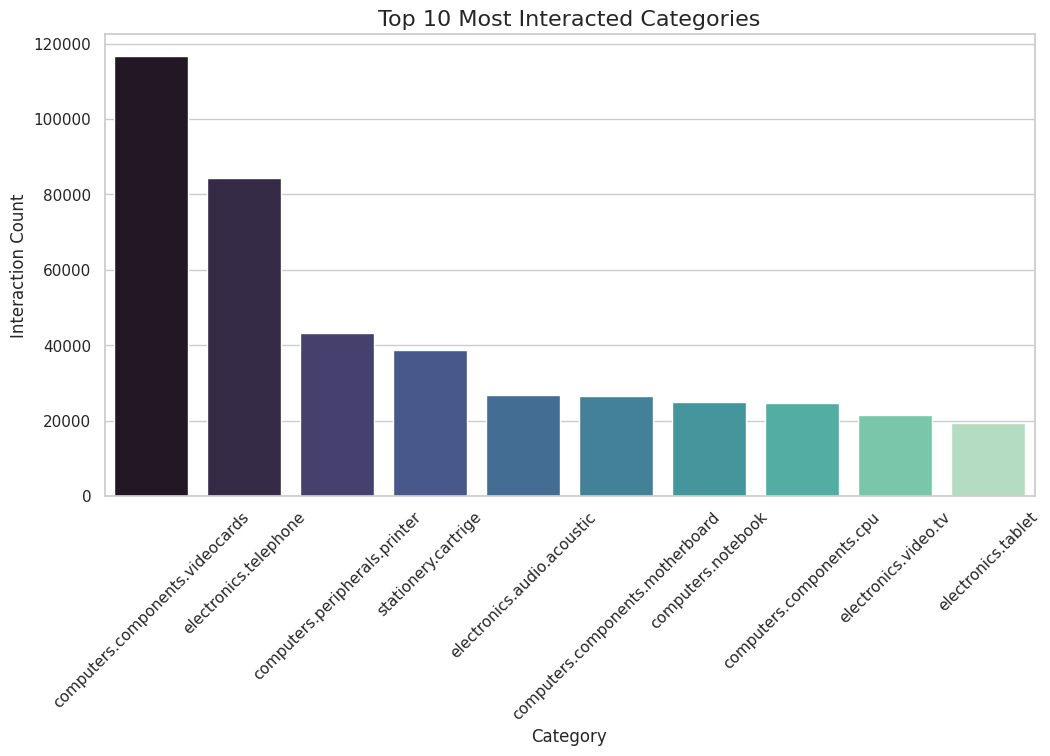

In [ ]:
top_categories = df['category_code'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.index, y=top_categories.values, palette='mako')
plt.title('Top 10 Most Interacted Categories', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Interaction Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

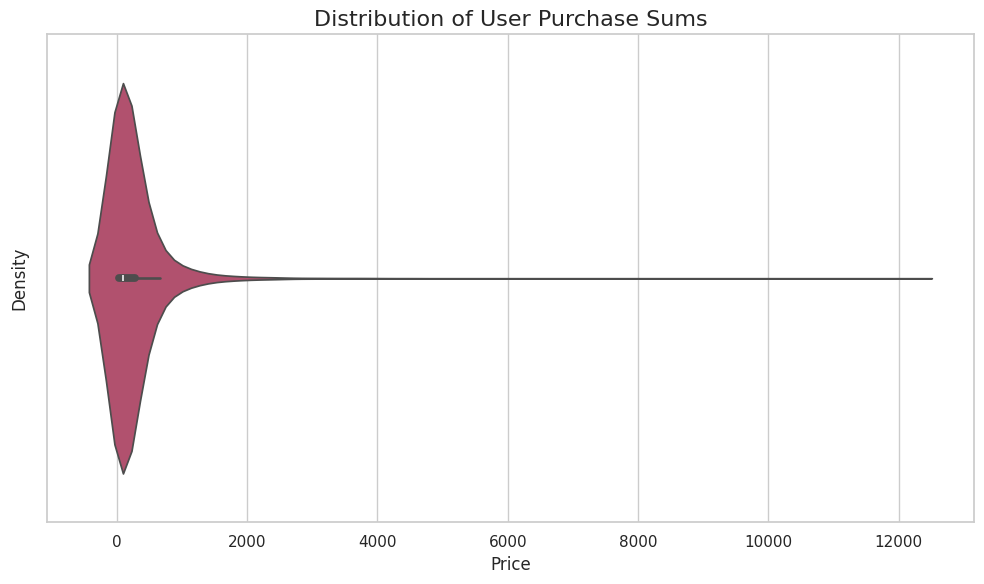

In [ ]:
purchase_df = df[df['event_type'] == "purchase"]
user_purchase_sums = purchase_df.groupby('user_id')['price'].sum().reset_index()
user_purchase_sums['price'] = user_purchase_sums['price'].round(2)
user_purchase_sums = user_purchase_sums.sort_values(by='price', ascending=False)

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.violinplot(data=user_purchase_sums, x='price', palette='flare', bw=0.5)
plt.title('Distribution of User Purchase Sums', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate temporal features
temporal_features = df.groupby('user_id').agg(
    first_interaction=('event_time', 'min'),
    last_interaction=('event_time', 'max')
).reset_index()

# Convert 'first_interaction' and 'last_interaction' to datetime objects
temporal_features['first_interaction'] = pd.to_datetime(temporal_features['first_interaction'], utc=True, errors='coerce')
temporal_features['last_interaction'] = pd.to_datetime(temporal_features['last_interaction'], utc=True, errors='coerce')

# Inactivity period: Days between the first and last interaction
temporal_features['customer_lifespan'] = (
    temporal_features['last_interaction'] - temporal_features['first_interaction']
).dt.days

# Days since last interaction: Days since the last recorded event
# Convert 'event_time' column to datetime first:
df['event_time'] = pd.to_datetime(df['event_time'], utc=True, errors='coerce')
temporal_features['days_since_last_interaction'] = (
    df['event_time'].max() - temporal_features['last_interaction']
).dt.days

# Display the resulting features
temporal_features.describe()

,user_id,customer_lifespan,days_since_last_interaction
count,4.072830e+05,407283.000000,407283.000000
mean,1.515916e+18,1.225239,78.484847
std,3.358013e+07,7.983615,45.328033
min,1.515916e+18,0.000000,0.000000
25%,1.515916e+18,0.000000,38.000000
50%,1.515916e+18,0.000000,81.000000
75%,1.515916e+18,0.000000,117.000000
max,1.515916e+18,156.000000,157.000000


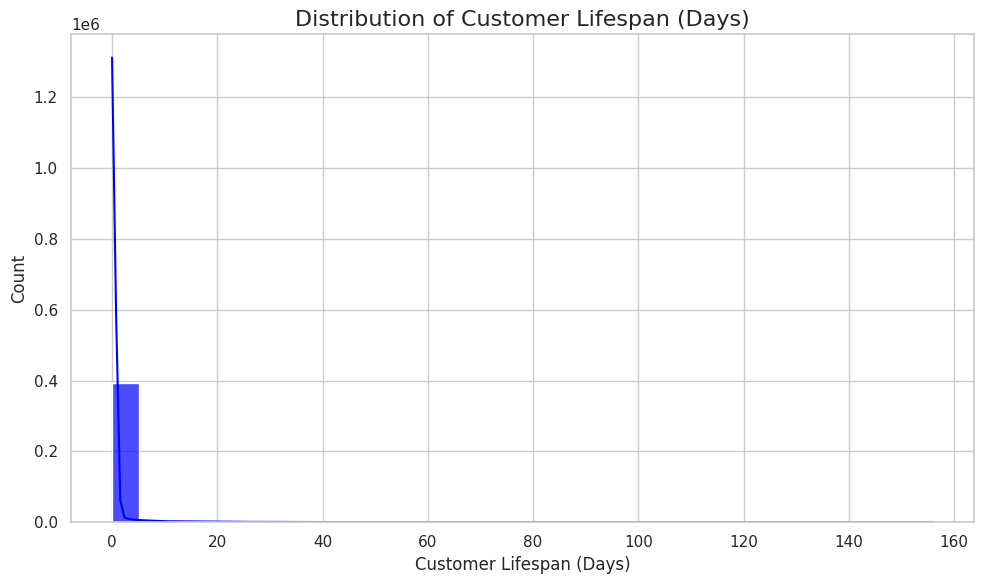

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(temporal_features['customer_lifespan'], bins=30, kde=True, color='blue', alpha=0.7)
plt.title('Distribution of Customer Lifespan (Days)', fontsize=16)
plt.xlabel('Customer Lifespan (Days)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

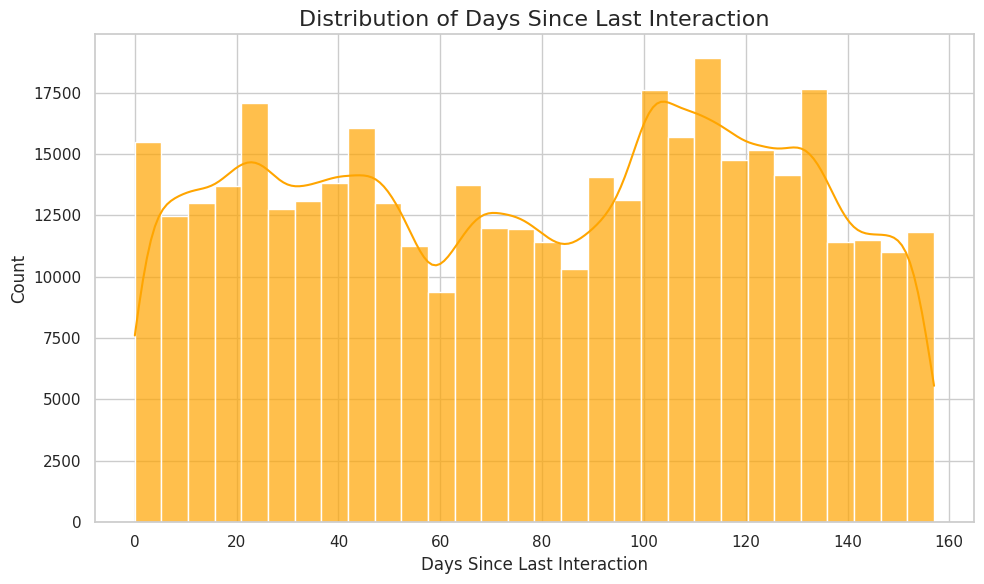

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(temporal_features['days_since_last_interaction'], bins=30, kde=True, color='orange', alpha=0.7)
plt.title('Distribution of Days Since Last Interaction', fontsize=16)
plt.xlabel('Days Since Last Interaction', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

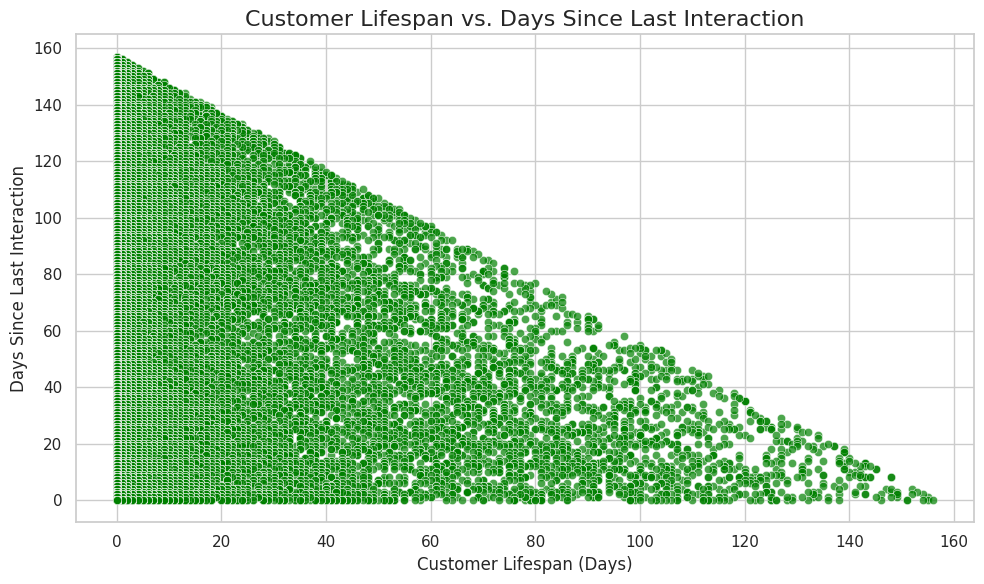

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=temporal_features,
    x='customer_lifespan',
    y='days_since_last_interaction',
    alpha=0.7,
    color='green'
)
plt.title('Customer Lifespan vs. Days Since Last Interaction', fontsize=16)
plt.xlabel('Customer Lifespan (Days)', fontsize=12)
plt.ylabel('Days Since Last Interaction', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Convert event_time to datetime (create a copy to avoid SettingWithCopyWarning)
data = df.copy()
data['event_time'] = pd.to_datetime(data['event_time'], utc=True, errors='coerce')

# Drop rows with missing user_session
data = data.dropna(subset=['user_session'])

# Fill missing values
data.loc[:, 'brand'] = data['brand'].fillna('unknown')
data.loc[:, 'category_code'] = data['category_code'].fillna('unknown')

# Sort data by user_id and event_time
data = data.sort_values(by=['user_id', 'event_time'])

# Calculate RFM metrics
rfm = data[data['event_type'] == 'purchase'].groupby('user_id').agg(
    recency=('event_time', lambda x: (data['event_time'].max() - x.max()).days),
    frequency=('event_time', 'count'),
    monetary=('price', 'sum')
).reset_index()

In [ ]:
# Convert event_time to datetime (create a copy to avoid SettingWithCopyWarning)
data = df.copy()
data['event_time'] = pd.to_datetime(data['event_time'], utc=True, errors='coerce')

# Drop rows with missing user_session
data = data.dropna(subset=['user_session'])

# Fill missing values
data.loc[:, 'brand'] = data['brand'].fillna('unknown')
data.loc[:, 'category_code'] = data['category_code'].fillna('unknown')

# Sort data by user_id and event_time
data = data.sort_values(by=['user_id', 'event_time'])

# Calculate RFM metrics
rfm = data.groupby('user_id').agg(
    recency=('event_time', lambda x: (data['event_time'].max() - x.max()).days),
    frequency=('event_time', 'count'),
    monetary=('price', 'sum')
).reset_index()

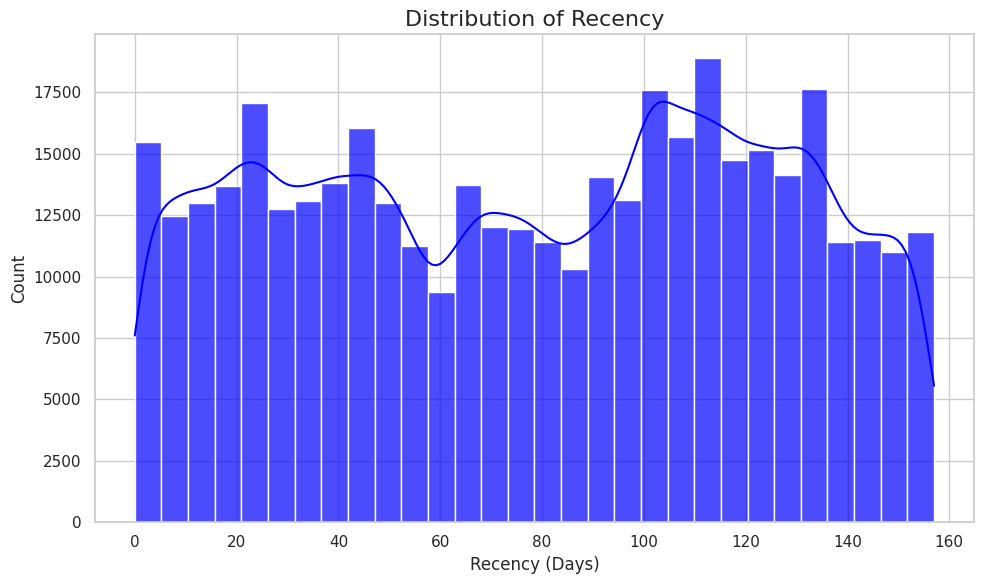

In [ ]:
# Visualization for 'recency'
plt.figure(figsize=(10, 6))
sns.histplot(rfm['recency'], bins=30, kde=True, color='blue', alpha=0.7)
plt.title('Distribution of Recency', fontsize=16)
plt.xlabel('Recency (Days)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

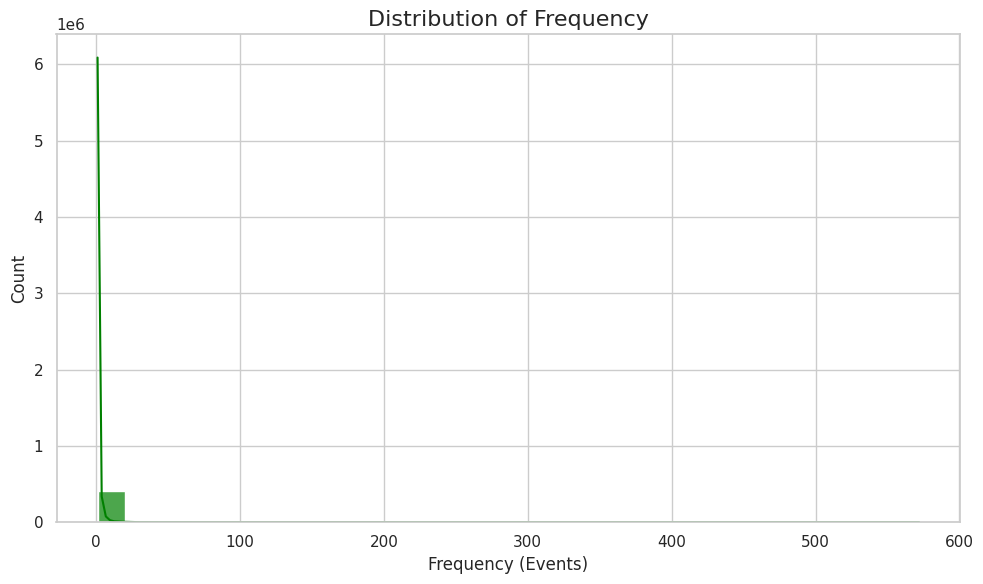

In [ ]:
# Visualization for 'frequency'
plt.figure(figsize=(10, 6))
sns.histplot(rfm['frequency'], bins=30, kde=True, color='green', alpha=0.7)
plt.title('Distribution of Frequency', fontsize=16)
plt.xlabel('Frequency (Events)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

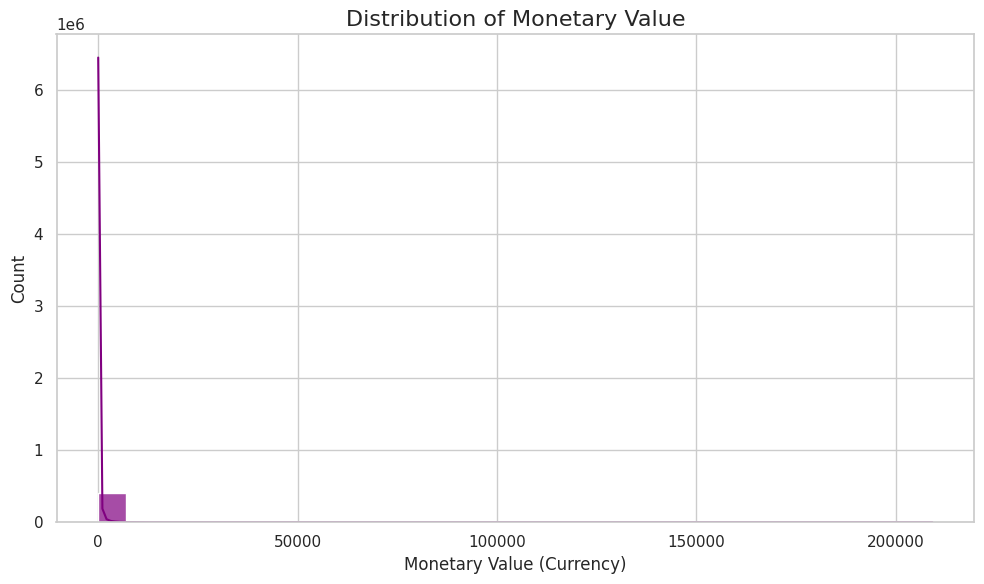

In [ ]:
# Visualization for 'monetary'
plt.figure(figsize=(10, 6))
sns.histplot(rfm['monetary'], bins=30, kde=True, color='purple', alpha=0.7)
plt.title('Distribution of Monetary Value', fontsize=16)
plt.xlabel('Monetary Value (Currency)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()